# Goals

Tag study, grant and dataType


In [1]:
# setup
import pandas as pd
import numpy as np
import ontologyScraper as ont
import textcleaning as tc
import re

In [2]:
# just for dev
%load_ext autoreload
%autoreload 2

In [3]:
# read in raw data from snowflake
df = pd.read_csv("./data/snowflakeData.csv", low_memory=False)

# potential features
df = df.loc[
    :,
    [
        "id",
        "PORTAL",
        "type",
        "name",
        "study",
        "assay",
        "dataType",
        "dataSubtype",
        "resourceType",
        "fileFormat",
        "grant",
        "parentId",
        "projectId",
        "studyId",
        "project",
        "Contributor",
        "PI",
    ],
]

# cols that are lists represented as strings
list_cols = ["study", "dataType", "assay", "grant"]

df[list_cols] = df[list_cols].apply(
    lambda x: x.str.replace('\n|\[|\]|"', "", regex=True).str.strip()
)

# fill in empty cells with nan's
df = df.replace("", np.nan)
df = df.replace("undefined", np.nan)
df = df.replace('\t', ' ', regex = False)

# EDA


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Attr', ylabel='Count'>

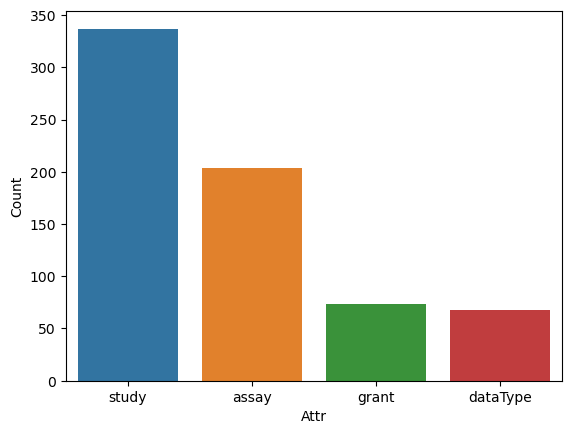

In [5]:
# unique values by column
unique_counts = df[list_cols].fillna("").apply(lambda x: len(np.unique(x)))
unique_counts = (
    pd.DataFrame(unique_counts)
    .reset_index()
    .rename(columns={"index": "Attr", 0: "Count"})
)
sns.barplot(unique_counts.sort_values(
    "Count", ascending=False), x="Attr", y="Count")

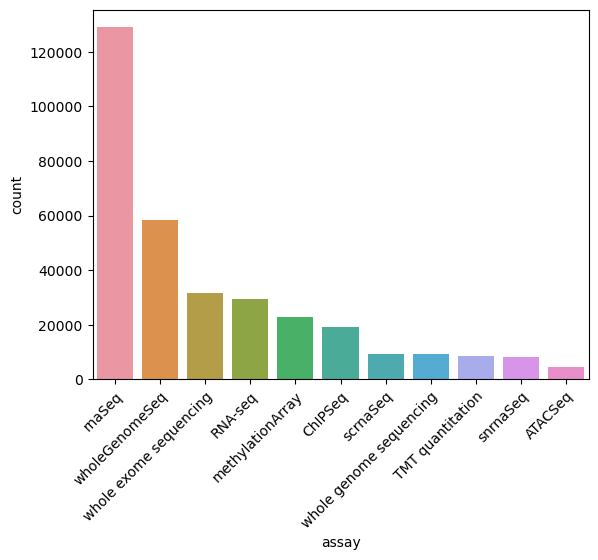

In [6]:
# similar labels
assay_counts = (
    pd.DataFrame(df["assay"].value_counts())
    .reset_index()
    .rename(columns={"index": "assay", "assay": "count"})
)

g = sns.barplot(x="assay", y="count", data=assay_counts.loc[:10, :])

g.set_xticklabels(g.get_xticklabels(), rotation=45,
                  ha="right", rotation_mode="anchor")

plt.show()

In [7]:
# Missing annotations

# Cleanup Attributes


In [8]:
# get spelling from public ontology source for assay
# vv_assay = ont.purl_main(
#     "http://purl.obolibrary.org/obo/OBI_0000070")
# vv_assay = pd.Series(vv_assay)
# vv_assay.to_csv('./data/valid_values_assay.csv')

vv_assay = (
    pd.read_csv("./data/valid_values_assay.csv")
    .drop(columns="Unnamed: 0")
    .rename(columns={"0": "values"})
)

In [9]:
import textcleaning as tc

In [10]:
# manually recode
assay_recoder = {
    "3D Confocal Imaging": "3D confocal imaging",
    "3D Confocal imaging": "3D confocal imaging",
    "3D confocal Imaging": "3D confocal imaging",
    "active avoidance learning behavior": "active avoidance learning behavior assay",
    "ATAC-seq": "ATAC-seq assay",
    "ATACseq": "ATAC-seq assay",
    "ATACSeq": "ATAC-seq assay",
    "bisulfite sequencing": "bisulfite sequencing assay",
    "bisulfiteSeq": "bisulfite sequencing assay",
    "Blood Chemistry Measurement": "blood chemistry measurement",
    "cell proliferation": "cell proliferation assay",
    "ChIP-Seq": "ChIP-seq assay",
    "ChIP-seq": "ChIP-seq assay",
    "ChIPSeq": "ChIP-seq assay",
    "contextual conditioning behavior": "contextual conditioning behavior assay",
    "electrophysiology": "electrophysiology assay",
    "exomeSeq": "whole exome sequencing",
    "flow cytometry": "flow cytometry assay",
    "Genotyping": "genotyping assay",
    "genotyping": "genotyping assay",
    "Immunoprecipitation": "immunoprecipitation assay",
    "immunoprecipitation": "immunoprecipitation assay",
    "liquid chromatography/tandem mass spectrometry": "liquid chromatography-tandem mass spectrometry",
    "mass spectrometry": "mass spectrometry assay",
    "methylationArray": "methylation array",
    "microscopy": "microscopy assay",
    "novelty response behavior": "novelty response behavior assay",
    "photography": "photograph",
    "polymerase chain reaction": "polymerase chain reaction assay",
    "polymeraseChainReaction": "polymerase chain reaction assay",
    "Positron Emission Tomography": "positron emission tomography",
    "RNA-seq": "RNA-seq	assay",
    "RNA-Seq": "RNA-seq assay",
    "RNA-seq\tassay": "RNA-seq assay",
    "rnaArray": "RNA array",
    "RNAseq": "RNA-seq assay",
    "rnaSeq": "RNA-seq assay",
    "RNASeq": "RNA-seq assay",
    "scATAC-seq assay": "single-cell ATAC-seq assay",
    "scATACSeq": "single-cell ATAC-seq assay",
    "scRNA-seq assay": "single-cell RNA sequencing assay",
    "scRNAseq": "single-cell RNA sequencing assay",
    "scrnaSeq": "single-cell RNA sequencing assay",
    "scwholeGenomeSeq": "single-cell whole genome sequencing assay",
    "single-cell RNA-seq": "single-cell RNA sequencing assay",
    "snATACSeq": "single-nucleus ATAC-seq assay",
    'snATAC-seq assay': "single-nucleus ATAC-seq assay",
    "snRNA-seq assay": "single-nucleus RNA sequencing assay",
    "snrnaSeq": "single-nucleus RNA sequencing assay",
    "T cell receptor repertoire sequencing": "T cell receptor repertoire sequencing assay",
    "TMT quantification": "TMT quantitation assay",
    "TMT quantitation": "TMT quantitation assay",
    "TMTquantitation": "TMT quantitation assay",
    "western blot": "western blot assay",
    "westernBlot": "western blot assay",
    "Whole Exome Sequencing": "whole exome sequencing assay",
    "whole exome sequencing": "whole exome sequencing assay",
    "whole genome sequencing": "whole genome sequencing assay",
    "whole-cell patch clamp": "whole-cell patch clamp assay",
    "wholeGenomeSeq": "whole genome sequencing assay",
}

# for reordering if necessary
# k = assay_recoder.keys()
# k = sorted(k, key=str.casefold)
# for ki in k:
#     print('"' + ki + '"' + ":" + '"' + assay_recoder[ki] + '"' + ",")

In [11]:
df = df.replace("\t", " ", regex=True)

In [12]:
# fuzzy matching to self
col_recode = "assay"

# A good cut off is 95, otherwise similar but not exact matches arise
df[col_recode] = df[col_recode].replace(assay_recoder, regex=True)

results = tc.fuzzy_matcher(
    df[col_recode], df[col_recode].fillna("").unique(), 90)

results["antCount"] = results["Annotation"].apply(
    lambda x: len(df[df[col_recode] == x])
)

with pd.option_context("display.max_rows", None):
    display(results)

# take the annotation with the best score match
idx = results.groupby("Annotation")["Score"].idxmax()

max_scores = (
    results.loc[idx]
    .sort_values(
        by=["Annotation", "Score"],
        key=lambda x: x.str.lower() if pd.api.types.is_string_dtype(x.dtype) else x,
    )
    .reset_index(drop=True)
)

# Works for most but not for example "whole exome sequencing" which matches to "whole genome sequencing assay" instead of "exome sequencing assay"

for k, v in assay_recoder.items():
    max_scores.loc[max_scores["Annotation"] == k, "ontologyWord"] = v

# max_scores

,Annotation,ontologyWord,Score,antCount
0,3D confocal imaging,Confocal imaging,91,6
1,active avoidance learning behavior assay,active avoidance learning behavior assay assay,98,3544
2,cell proliferation assay,cell proliferation assay assay,98,9
3,contextual conditioning behavior assay,contextual conditioning behavior assay assay,99,3
4,novelty response behavior assay,novelty response behavior assay assay,98,275
5,whole exome sequencing,whole genome sequencing assay,91,625
6,whole exome sequencing,whole exome sequencing assay,98,625


In [13]:
# fuzzy matching to ontology
col_recode = "assay"

# A good cut off is 95, otherwise similar but not exact matches arise
results = tc.fuzzy_matcher(df[col_recode], vv_assay["values"], 90)
results["antCount"] = results["Annotation"].apply(
    lambda x: len(df[df[col_recode] == x])
)

with pd.option_context("display.max_rows", None):
    display(results)

,Annotation,ontologyWord,Score,antCount
0,liquid chromatography-tandem mass spectrometry...,liquid chromatography-tandem mass spectrometry,93,10
1,RNA fluorescence in situ hybridization,fluorescence in-situ hybridization assay,92,1
2,T cell receptor repertoire sequencing assay,B cell receptor repertoire sequencing assay,91,20
3,whole exome sequencing,whole genome sequencing assay,91,625


In [14]:
df[col_recode] = df[col_recode].replace(assay_recoder, regex=False)
df = df.replace("assay assay", "assay", regex=True)

In [15]:
sorted(df['assay'].dropna().unique(),key=str.casefold)

['10x multiome',
 '16SrRNA-seq assay',
 '2D AlamarBlue fluorescence',
 '2D CellTiter-Glo',
 '2D Incucyte',
 '3D confocal imaging',
 '3D electron microscopy assay',
 '3D imaging',
 '3D microtissue viability',
 'active avoidance learning behavior assay',
 'anxiety-related behavior',
 'array',
 'ATAC-seq assay',
 'atomic force microscopy assay',
 'ATPase activity assay',
 'autoradiography',
 'Baker Lipidomics',
 'Biocrates Bile Acids',
 'Biocrates Bile Acids,  Biocrates p180,  Metabolon',
 'Biocrates p180',
 'bisulfite sequencing assay',
 'blood chemistry measurement',
 'blue native PAGE',
 'body size trait measurement',
 'brightfield microscopy assay',
 'Bulk RNA sequencing',
 'calcium retention capacity assay',
 'cAMP-Glo Max Assay',
 'cell competition',
 'cell count',
 'cell proliferation assay',
 'cell viability assay',
 "Children's Dermatology Life Quality Index Questionnaire",
 'ChIP-seq assay',
 'CITESeq',
 'clinical data',
 'cNF-Skindex',
 'Confocal imaging',
 'confocal microscopy

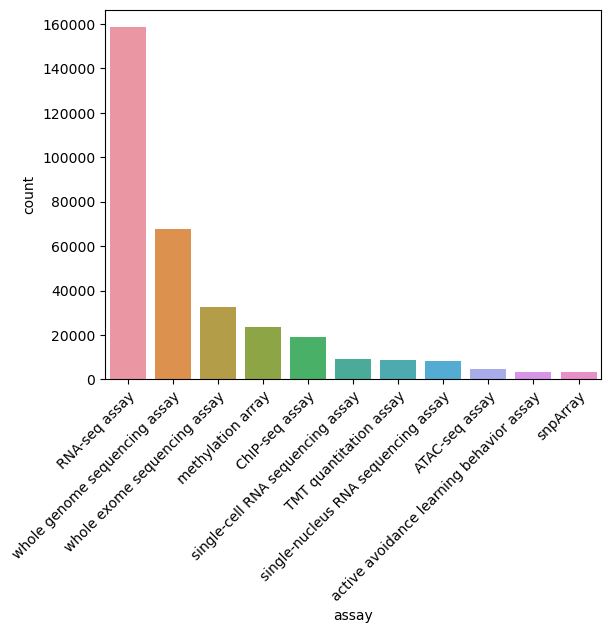

In [16]:
# similar labels
assay_counts = (
    pd.DataFrame(df["assay"].value_counts())
    .reset_index()
    .rename(columns={"index": "assay", "assay": "count"})
)

g = sns.barplot(x="assay", y="count", data=assay_counts.loc[:10, :])

g.set_xticklabels(g.get_xticklabels(), rotation=45,
                  ha="right", rotation_mode="anchor")

plt.show()

In [17]:
assay_counts.iloc[:20, :]

,assay,count
0,RNA-seq assay,158494
1,whole genome sequencing assay,67540
2,whole exome sequencing assay,32671
3,methylation array,23600
4,ChIP-seq assay,19205
5,single-cell RNA sequencing assay,9360
6,TMT quantitation assay,8912
7,single-nucleus RNA sequencing assay,8163
8,ATAC-seq assay,4668
9,active avoidance learning behavior assay,3545


Fix studies


In [18]:
datatype_recoder = {"Analysis": "analysis", "Volume": "volume"}

# fix data type
sorted(df["dataType"].fillna("").unique(), key=str.casefold)

df["dataType"] = df["dataType"].replace(datatype_recoder)

In [19]:
# fix resourceType
fix_col = "resourceType"

recoder = {"ExperimentalData": "experimentalData", " tool": "tool"}

# fix data type
sorted(df[fix_col].fillna("").unique(), key=str.casefold)

df[fix_col] = df[fix_col].replace(recoder)

In [20]:
df.columns

Index(['id', 'PORTAL', 'type', 'name', 'study', 'assay', 'dataType',
       'dataSubtype', 'resourceType', 'fileFormat', 'grant', 'parentId',
       'projectId', 'studyId', 'project', 'Contributor', 'PI'],
      dtype='object')

In [21]:
# fix resourceType
fix_col = "dataSubtype"

recoder = {"ExperimentalData": "experimentalData", " tool": "tool"}

# fix data type
sorted(df[fix_col].fillna("").unique(), key=str.casefold)

# df[fix_col] = df[fix_col].replace(recoder)

['',
 'bundle',
 'clinical',
 'Copy Number Segments',
 'dataMatrix',
 'md5',
 'metadata',
 'normalized',
 'preprocessed',
 'processed',
 'raw',
 'raw,processed',
 'report',
 'representative',
 'residualized',
 'SNP variants',
 'structural variants']

In [22]:
# fix resourceType
fix_col = "fileFormat"

recoder = {
    "Bash script": "bash script",
    "R script": "R",
    "synapse Table": "Synapse Table",
    "Python script": "py",
}

# fix data type
print(sorted(df[fix_col].fillna("").unique(), key=str.casefold))

df[fix_col] = df[fix_col].replace(recoder)

['', '.gz', '7z', 'AB1', 'abf', 'ai', 'avi', 'bai', 'bam', 'bash script', 'Bash script', 'bat', 'bed', 'bed broadPeak', 'bed gappedPeak', 'bed narrowPeak', 'bedgraph', 'bgzip', 'bias', 'bigwig', 'bim', 'bpm', 'bsc', 'cel', 'cfg', 'chp', 'cnn', 'cnr', 'cns', 'config', 'cov', 'crai', 'cram', 'csi', 'css', 'csv', 'csv ', 'ctab', 'czi', 'dat', 'db', 'DICOM', 'dict', 'doc', 'docx', 'excel', 'fa', 'fai', 'fam', 'fasta', 'fastq', 'Fastq', 'fcs', 'feather', 'flagstat', 'fna', 'gct', 'gif', 'gmt', 'gtf', 'gvcf', 'gz', 'gzip', 'h5ad', 'hdf', 'hdf5', 'hic', 'html', 'hyperlink', 'idat', 'idx', 'idxstats', 'jar', 'jpg', 'js', 'json', 'locs', 'log', 'maf', 'matrix', 'md5', 'mov', 'mp4', 'msf', 'mtx', 'mzML', 'nii', 'out', 'pdf', 'pdresult', 'pdstudy', 'pdview', 'pepXML', 'plink', 'png', 'powerpoint', 'powerPoint', 'Python script', 'pzf', 'pzfx', 'R', 'R script', 'raw', 'RCC', 'RData', 'Rdata', 'rds', 'recal', 'RLF', 'Rscript', 'saf', 'sdf', 'seg', 'Sentrix descriptor file', 'SEQ', 'sf', 'sf3', 'sqli

In [23]:
# fix resourceType
fix_col = "PI"

recoder = {}

# fix data type
print(sorted(df[fix_col].fillna("").unique(), key=str.casefold))

df[fix_col] = df[fix_col].replace(recoder)

['', 'Andrew Jaffe', 'Chunyu Liu', 'Chunyu Liu, Kevin White', 'Dalila Pinto', 'Dan Geschwind', 'Daniel Geschwind', 'Flora Vaccarino', 'Greg Crawford', 'Gregory Crawford', 'James Knowles', 'Nenad Sestan', 'Nenad Sestan, Matt State', 'Peggy Farnham, James Knowles', 'Peter Zandi', 'Peter Zandi, Thomas Hyde', 'Schahram Akbarian', 'Shyam Prabhakar', 'Stella Dracheva', 'Stella Dracheva, Schahram Akbarian']


In [24]:
# file formats
# file_formats = ont.purl_main('http://edamontology.org/format_1915')
# pd.Series(file_formats).to_csv('./data/file-formats.csv', index = False)
file_formats = pd.read_csv(
    "./data/file-formats.csv").rename(columns={"0": "values"})

In [25]:
results = tc.fuzzy_matcher(df["fileFormat"], file_formats["values"], 100)
results = results.loc[~results["ontologyWord"].isin(["SAM", "SS"])]
results

,Annotation,ontologyWord,Score
1,bai,BAI,100
2,bam,BAM,100
3,bed,BED,100
4,bigwig,bigWig,100
5,chp,CHP,100
6,cram,CRAM,100
7,csv,CSV,100
8,Fastq,FASTQ,100
9,fastq,FASTQ,100
10,gif,GIF,100


In [26]:
recoder = dict(zip(results["Annotation"], results["ontologyWord"]))

In [27]:
df["fileFormat"] = df["fileFormat"].replace(recoder)

In [28]:
results = tc.fuzzy_matcher(df["fileFormat"], file_formats["values"], 85)
results = results.loc[~results["ontologyWord"].isin(["SAM", "SS"])]
results

,Annotation,ontologyWord,Score
1,BED,bed6,86
2,csv,CSV,86
3,dat,IDAT,86
4,doc,docx,86
5,fasta,FASTA,89
6,FASTQ,FASTA,89
7,gvcf,GVF,86
8,gvcf,VCF,86
9,gzip,bgzip,89
10,HDF,HDF5,86


In [29]:
new_terms = [
    "TXT",
    "mzXML",
    "mds",
    "sf3",
    "tbz",
    "drv",
    "crai",
    "dbm",
    "svs",
    "svg",
    "tmp",
    "unr",
    "gmt",
    "R",
    "Rmd",
    "Rdata",
    "fam",
    "gz",
    "h5",
    "hdr",
    "img",
    "tgz",
    "XSL",
    "XLS",
    "zip",
    "seq",
    "rtf",
    "sh",
    "doc",
    "bgz",
    "bib",
]

for n in new_terms:
    file_formats.loc[len(file_formats) + 1, "values"] = n

file_formats = file_formats.drop_duplicates(subset="values")

In [30]:
recoder = recoder | {
    "Rscript": "R script",
    "fasta": "FASTA",
    "Tif": "TIF",
    "tif": "TIF",
    "xls": "XLS",
    "XLSX": "xlsx",
    "RAW": "raw",
    "yml": "YAML",
    "yaml": "YAML",
}

In [31]:
file_formats

,values
0,.nib
1,2bit
2,3D-1D scoring matrix format
3,A2M
4,AB1
...,...
638,rtf
639,sh
640,doc
641,bgz


In [32]:
df["fileFormat"] = df["fileFormat"].str.strip().replace(recoder)

In [33]:
fileFormats_og = set(df["fileFormat"].unique())
print(
    f"Percent of missing file formats: {round(sum(df['fileFormat'].isnull())/len(df) * 100, 2)}"
)
# easy pass
df.loc[:, "fileExtensions"] = df.loc[:, "name"].str.rsplit(
    r".", n=1, expand=True)[1]

Percent of missing file formats: 37.35


In [34]:
results = tc.fuzzy_matcher(
    df["fileExtensions"].str.strip(), file_formats["values"], 100
)

results = results.loc[~results["ontologyWord"].isin(["SAM", "SS"])]

recoder = recoder | dict(zip(results["Annotation"], results["ontologyWord"]))

checker = list(file_formats["values"])

df["fileExtensions"] = (
    df["fileExtensions"]
    .fillna("")
    .apply(
        lambda x: x
        if x in checker or bool(re.match("[a-zA-Z]", x)) and len(x) < 7
        else np.nan
    )
)

df["fileExtensions"] = df["fileExtensions"].str.strip().replace(recoder)

print(len(set(df["fileExtensions"].fillna("").unique()) - set(file_formats["values"])))
set(df["fileExtensions"].fillna("").unique()) - set(file_formats["values"])

139


{'',
 'Ax_T1',
 'PAR',
 'RDS',
 'RDa',
 'RData',
 'RDs',
 'REC',
 'Rout',
 'S',
 'SDAT',
 'SPAR',
 'S_POST',
 'TIF',
 'V12',
 'ab1',
 'abf',
 'ai',
 'anno',
 'avi',
 'bak',
 'bat',
 'bg',
 'bias',
 'bim',
 'block',
 'bpm',
 'bsc',
 'bw',
 'bz2',
 'c4gh',
 'cdr',
 'cds',
 'cfg',
 'cloupe',
 'cnn',
 'cnr',
 'cns',
 'concat',
 'config',
 'count',
 'covtsf',
 'cpn',
 'csi',
 'css',
 'ctab',
 'czi',
 'czii',
 'db',
 'dbsnp',
 'dcm',
 'dict',
 'drp',
 'drs',
 'edat3',
 'eds',
 'emf',
 'enl',
 'evs',
 'fa',
 'fai',
 'fcs',
 'fq',
 'gct',
 'gistic',
 'h5ad',
 'hh',
 'hic',
 'idx',
 'in',
 'ind',
 'ipynb',
 'js',
 'key',
 'len',
 'limits',
 'lmix',
 'locs',
 'log',
 'lsf',
 'm',
 'm2',
 'mate1',
 'mate2',
 'matrix',
 'md5',
 'mdd',
 'mov',
 'mp4',
 'mqd',
 'nhr',
 'nin',
 'nsq',
 'out',
 'output',
 'pb',
 'pbi',
 'pcrd',
 'pep',
 'pm',
 'ppt',
 'props',
 'ps',
 'pst',
 'psydat',
 'py',
 'pzf',
 'pzfx',
 'qc',
 'rData',
 'rawcnv',
 'rcnt',
 'rda',
 'rds',
 'recal',
 'rel',
 'report',
 'rlf',
 's

In [35]:
print(
    f"Percentage of overlaping file extensions: {round(sum(df['fileFormat'] == df['fileExtensions']) / len(df) * 100,2)}"
)

df["fileFormat"] = df["fileFormat"].fillna(df["fileExtensions"])

print(
    f"Percent of missing file formats after quick cleaning: {round(sum(df['fileFormat'].isnull())/len(df) * 100, 2)}"
)

fileFormats_new = set(df["fileFormat"].unique())

print(len(fileFormats_og), len(fileFormats_new))
print(fileFormats_new - fileFormats_og)

Percentage of overlaping file extensions: 25.79
Percent of missing file formats after quick cleaning: 7.47
134 227
{'pm', 'MAT', 'S_POST', 'dbm', 'PAR', 'bz2', 'ipynb', 'h5', 'XSL', 'rData', 'qual', 'sortu', 'limits', 'img', 'pickle', 'report', 'PED', 'output', 'dcm', 'sh', 'nin', 'edat3', 'gistic', 'pb', 'hh', 'drv', 'ind', 'scn', 'cds', 'mate2', 'spk', 'lmix', 'mdd', 'REC', 'c4gh', 'dna', 'WIG', 'SPAR', 'bw', 'tmp', 'block', 'len', 'xlsb', 'table', 'Ax_T1', 'SDAT', 'enl', 'Pileup', 'nhr', 'psydat', 'drp', 'S', 'wndpos', 'cpn', 'drs', 'BMP', 'eds', 'ab1', 'Rmd', 'rtf', 'tgz', 'mate1', 'covtsf', 'pep', 'MAP', 'TIFF', 'key', 'seq', 'XLS', 'pbi', 'm', 'emf', 'qc', 'cloupe', 'sizes', 'vloupe', 'bib', 'cdr', 'sam', 'count', 'RDa', 'pst', 'mds', 'val', 'concat', 'nsq', 'LSM', 'TXT', 'pptx', 'Rout', 'in', 'hdr', 'size'}


In [36]:
df["fileFormat"] = df["fileExtensions"].fillna(df["fileFormat"])
# df["fileFormat"] = df["fileFormat"].fillna(df['fileExtensions'])

In [37]:
df["fileFormat"]

0         crai
1         crai
2         crai
3         crai
4         crai
          ... 
583172     CSV
583173     CSV
583174     CSV
583175     TXT
583176     TXT
Name: fileFormat, Length: 583177, dtype: object

In [38]:
df = df.drop(columns=["fileExtensions"])

In [39]:
df[df["fileFormat"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43543 entries, 107326 to 576209
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            43543 non-null  object 
 1   PORTAL        43543 non-null  object 
 2   type          43208 non-null  object 
 3   name          43543 non-null  object 
 4   study         10985 non-null  object 
 5   assay         979 non-null    object 
 6   dataType      653 non-null    object 
 7   dataSubtype   297 non-null    object 
 8   resourceType  662 non-null    object 
 9   fileFormat    0 non-null      object 
 10  grant         0 non-null      object 
 11  parentId      43543 non-null  object 
 12  projectId     43513 non-null  object 
 13  studyId       10900 non-null  object 
 14  project       0 non-null      float64
 15  Contributor   0 non-null      object 
 16  PI            21 non-null     object 
dtypes: float64(1), object(16)
memory usage: 6.0+ MB


# cleanup "types"


In [40]:
df.loc[
    df["name"].str.contains("Dictionary", flags=re.IGNORECASE), "metadataType"
] = "dataDictionary"

In [41]:
df.loc[
    (df["name"].str.contains("metadata", flags=re.IGNORECASE))
    & (df["resourceType"].isnull())
    & (~df["fileFormat"].isin(["py", "ipynb"])),
    "resourceType",
] = "metadata"

In [42]:
df.loc[
    (df["name"].str.contains("metadata", flags=re.IGNORECASE))
    & (df["resourceType"].isnull()),
]

,id,PORTAL,type,name,study,assay,dataType,dataSubtype,resourceType,fileFormat,grant,parentId,projectId,studyId,project,Contributor,PI,metadataType
72197,syn17020593,ad,NaN,clinical_metadata_helpers.py,NaN,NaN,NaN,NaN,NaN,py,NaN,syn17020592,syn2580853,NaN,NaN,NaN,NaN,NaN
72198,syn17020594,ad,NaN,clinical_metadata_table.ipynb,NaN,NaN,NaN,NaN,NaN,ipynb,NaN,syn17020592,syn2580853,NaN,NaN,NaN,NaN,NaN


In [43]:
df.loc[df["dataSubtype"].isnull(),]

,id,PORTAL,type,name,study,assay,dataType,dataSubtype,resourceType,fileFormat,grant,parentId,projectId,studyId,project,Contributor,PI,metadataType
1419,syn52622973,ad,NaN,Dummy data file.xlsx,NaN,NaN,NaN,NaN,NaN,xlsx,NaN,syn52236801,syn2580853,NaN,NaN,NaN,NaN,NaN
1420,syn52623628,ad,NaN,synapse_storage_manifest_.csv,NaN,NaN,NaN,NaN,NaN,CSV,NaN,syn52236799,syn2580853,NaN,NaN,NaN,NaN,NaN
1445,syn3169023,ad,NaN,AMP-AD_HBTRC_MSSM_Agilent44Karray_PFC_AgeCorre...,HBTRC,RNA array,geneExpression,NaN,experimentalData,TSV,U01AG046170,syn20808200,syn2580853,NaN,NaN,NaN,NaN,NaN
1446,syn3169026,ad,NaN,AMP-AD_HBTRC_MSSM_Agilent44Karray_Covariates,HBTRC,snpArray,genomicVariants,NaN,metadata,TSV,U01AG046170,syn16944513,syn2580853,NaN,NaN,NaN,NaN,NaN
1450,syn3173724,ad,NaN,Emory_Emory_LTQOrbitrapXL_ADPD,Emory_ADRC,LC-MSMS,proteomics,NaN,experimentalData,raw,U01AG046161,syn9884385,syn2580853,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583172,syn27369676,elite,file,FEV1_FVC_metaX.csv,Aging-PheWAS,NaN,NaN,NaN,analysis,CSV,U24AG051129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583173,syn27369682,elite,file,FEV1_metaX.csv,Aging-PheWAS,NaN,NaN,NaN,analysis,CSV,U24AG051129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583174,syn27369699,elite,file,FN_BMD_metaX.csv,Aging-PheWAS,NaN,NaN,NaN,analysis,CSV,U24AG051129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583175,syn27373432,elite,file,AgingPheWAS_GWASfiles_dataDictionary.txt,Aging-PheWAS,NaN,NaN,NaN,metadata,TXT,U24AG051129,NaN,NaN,NaN,NaN,NaN,NaN,dataDictionary


In [44]:
df.loc[(~df["fileFormat"].isnull()) & (df["type"].isnull()), "type"] = "file"

In [45]:
df.to_csv("./data/cleaned-data-20231031.csv", index=False)